# COFFEE DATASET

Demo for unsupervised brute force shaplets searching for anomaly detection 

In [4]:
import os 
os.chdir('/home/ludovicobartoli/Documents/Shapelets')

import numpy as np
import random

from tslearn.datasets import CachedDatasets, UCR_UEA_datasets
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance

from src.preprocessing_anomaly import preprocessing_anomaly
from src.SVDD.SVDD import SVDD
from src.util import Scaler, euclidean_distance_shifted, length_normalized_distance, max_corr
from src.searching.bruteforce_multivariate import Bruteforce_extractor_mv, Candidateset
from src.searching.RLS import RLS_extractor, RLS_candidateset

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.svm import OneClassSVM

import matplotlib.pyplot as plt
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"


## Set up the dataset

### Load the data

Download the data (if needed):

In [5]:
data_name = "Coffee"
X_train = np.load(f'demo/data/{data_name}_train.npy')
y_train = np.load(f'demo/data/{data_name}_train_labels.npy')
X_test = np.load(f'demo/data/{data_name}_test.npy')
y_test = np.load(f'demo/data/{data_name}_test_labeles.npy')

print(f'Shape of training data: {X_train.shape}')
print(f'Shape of test data: {X_test.shape}')
print(f'The different classes: {set(y_train)}')

Shape of training data: (28, 286, 1)
Shape of test data: (28, 286, 1)
The different classes: {0, 1}


### Preprocessing

#### Get statistics of the entire data:

In [6]:
X_total = np.concatenate((X_train, X_test), axis=0)
y_total = np.concatenate((y_train, y_test), axis=0)
print(f'Shape of the total data: {X_total.shape}')

#### check if one class is predominant
obs_perclass = [len(y_total[y_total==i]) for i in set(y_total)]
print(f'Number of total samples in each class: {obs_perclass}')

Shape of the total data: (56, 286, 1)
Number of total samples in each class: [29, 27]


Plot one sample per class:

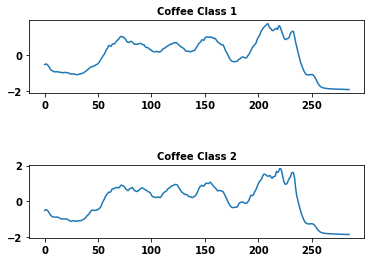

In [7]:
n_class = len(obs_perclass)

fig, ax = plt.subplots(n_class,)

# NOTE: modify if the labels start from 0 or 1
for i in range(n_class):
    ts = X_train[y_train==i][0,:,0]
    ax[i].set_title(f'{data_name} Class {i+1}', fontsize=10, fontweight="bold")
    ax[i].plot(ts)
plt.subplots_adjust(hspace=1)
plt.show()

#### Create anomaly detection dataset:

In [8]:
np.random.seed(0)
# Set up anomaly detection dataset

normal_class = 0 # choose the normal class
normal_prop = 0.8 # proportion of normal samples that go in train set
alpha = 0.05 # proportion of anomalies wrt normal 
X_train_anomaly, y_train_anomaly, X_test_anomaly, y_test_anomaly = preprocessing_anomaly(X_train, y_train, X_test, y_test, alpha, normal_class=normal_class, normal_prop=normal_prop)

N, Q, n_channels = X_train_anomaly.shape
print(f'{data_name} dataset')
print(f'number train ts is {N}, each of length {Q}')
print(f'They belong to two possible classes: {set(y_train_anomaly)}')
print('number test ts', len(X_test_anomaly))
print('number of normal train series:', len(y_train_anomaly[y_train_anomaly==1]))
print('number of anomalous train series:', len(y_train_anomaly[y_train_anomaly==-1]))
print('number of normal test series:', len(y_test_anomaly[y_test_anomaly==1]))
print('number of anomalous test series:', len(y_test_anomaly[y_test_anomaly==-1]))

Coffee dataset
number train ts is 24, each of length 286
They belong to two possible classes: {1, -1}
number test ts 32
number of normal train series: 23
number of anomalous train series: 1
number of normal test series: 6
number of anomalous test series: 26


#### Normalize using MinMax scaler:

In [9]:
# normalize the time series
# as in the tutorial https://tslearn.readthedocs.io/en/stable/auto_examples/classification/plot_shapelets.html#sphx-glr-auto-examples-classification-plot-shapelets-py
scaler = TimeSeriesScalerMinMax()
X_train_anomaly = scaler.fit_transform(X_train_anomaly)
X_test_anomaly = scaler.transform(X_test_anomaly)

#### Plot train set

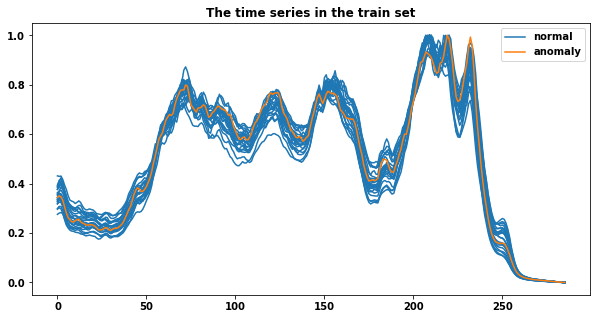

In [10]:
plt.figure(figsize=(10, 5))
for i in range(len(X_train_anomaly[y_train_anomaly==1][:,:,0])):
    ts = X_train_anomaly[y_train_anomaly==1][i,:,0]
    plt.plot(range(len(ts)), ts, c='tab:blue', label='normal' if i==0 else None)
for i in range(len(X_train_anomaly[y_train_anomaly==-1][:,:,0])):
    ts = X_train_anomaly[y_train_anomaly==-1][i,:,0]
    plt.plot(range(len(ts)), ts, c='tab:orange', label='anomaly' if i==0 else None)
plt.legend()
plt.title('The time series in the train set', fontweight="bold")
plt.show()
# plt.savefig('trace34_train')


## BruteForce algorithm 

Set up the parameters:

In [11]:
extractor_bf = Bruteforce_extractor_mv(train_data=X_train_anomaly, test_data=X_test_anomaly)

K_star = 0.02 # number of shapelets in proportion to length of time series
L_star = 0.2 # length of shapelets in proportion to length of time series
L = round(L_star * Q)
K = round(K_star*Q)

# REVERSE indicates whether the extracted shapelets are the furthest (True) or the nearest (False) to the majority of the time series
reverse = False
corr_threshold = 0.8
pos_boundary = None

# # extract the shapelets
# shapelets = extractor_bf.extract_shapelets(K_star, L_star, pos_boundary=pos_boundary, corr_threshold=corr_threshold, reverse=reverse, sample_size=3000)
# S = shapelets.sequences
# np.save(f'../Results/Trace34/s_reverse=pos_boundary={pos_boundary}_corr_threshold={corr_threshold}', S)

Try with other parameters:

In [12]:
# # try with other parameters 
# pos_boundary = 20
# corr_threshold = None
# shapelets = extractor_bf.get_top_candidates(K, pos_boundary, corr_threshold, reverse, sample_size=3000)
# S = shapelets.sequences
# np.save(f'results/{data_name}/s_reverse=pos_boundary={pos_boundary}_corr_threshold={corr_threshold}', S)


Load the results:

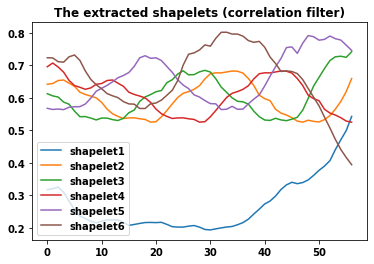

In [13]:
# or load the results
S = np.load(f'results/{data_name}/s_corr_threshold={corr_threshold}_pos_boundary={pos_boundary}_L={L}.npy')
extractor_bf.shapelets = Candidateset()
extractor_bf.shapelets.sequences = S

channel = 0
plt.figure()
for i in range(len(S)):
    shap = S[i,:,channel]
    plt.plot(shap, label=f'shapelet{i+1}')
plt.legend()
plt.title('The extracted shapelets (correlation filter)', fontweight="bold")
plt.show()

In [15]:
# test correlation of the shapelets
corr_matrix = np.zeros((K,K))
for i in range(len(S)):
   for j in range(len(S)):
       corr_matrix[i,j] = max_corr(S[i], S[j])
print(corr_matrix)

[[1.         0.50365957 0.46123788 0.37122866 0.61817722 0.49107952]
 [0.50365957 1.         0.74161269 0.79018345 0.726997   0.7735711 ]
 [0.46123788 0.74161269 1.         0.60715915 0.77927795 0.62511761]
 [0.37122866 0.79018345 0.60715915 1.         0.61025124 0.57304554]
 [0.61817722 0.726997   0.77927795 0.61025124 1.         0.62737228]
 [0.49107952 0.7735711  0.62511761 0.57304554 0.62737228 1.        ]]


## RLS algorithm

RLS ALGORITHM:
- Extract K suboptimal shapelets with lengths in {L_min, L_min+step, L_min+2*step, .... , L_max}
- First take all the subsequences of such lengths and select randomly r of them
- Compute the scores only for the r ones and take the best m
- Search among each of the m best candidates' neighbors with radius epsilon:
if j is the position and L the length of a candidate, the neighborhood is defined as the subsequences not scored that satisfy
\begin{equation}
    |position - j| \le epsilon[0], \qquad |length - L| \le step*epsilon[1]
\end{equation}
- Whenever a neighborhood is found, compute the scores only for a percentage (1-beta) of its members 
- If a better candidate is found in a neighborhood, iteratively search in its neighborhood, for a maximum of n_iter.
- When the Local Search is ended, take the best K candidates from the scored so far.

Set up the RLS extractor and hyperparameters:
- K_star: number of shapelets in proportion to length of time series Q
- L_min, step, n_step: range of shapelets lengths [L_min, L_min + step*n_steps]
- r: number of candidates to be selected randomly for calculating scores at the beginning (should be not too small)
- m: best candidates to take in order to perform LocalSearch in their neighborhood
- epsilon: (eps[0], eps[1]): radius for neighborhood wrt position, length. 
- beta: percentage of neighbors to eliminate (not compute scores) each time a neighborhood is found 
- maxiter: maximum number of neighborhood search for each of the m best candidates
- reverse: bool, whether to take the shapelets with max (True) or min score

In [17]:
K_star = 0.02
K = round(K_star*Q)

L_star = 0.2
L = round(L_star*Q)
L_min = L
step = 1
n_steps = 0
L_max = L_min + step*n_steps
print(f'The range of lengths is from {L_min} to {L_max}')

r = 500 # initial random candidates
m = K
pos_boundary = None
corr_boundary = 0.8
reverse = False
epsilon = (2,1)
beta = 0.7 # eliminate beta% of neighbors
maxiter = 4
aucs = []
scored = []
f1s = []

The range of lengths is from 57 to 57


Give average AUC and F1 scores over 10 different runs of the algorithm:

In [ ]:
for seed in range(10):
    print(f'Seed: {seed}')
    np.random.seed(seed)
    extractor = RLS_extractor(train_data=X_train_anomaly, test_data=X_test_anomaly)
    print(f'Total candidates: {extractor.total_candidates}')
    # range of lengths! 
    shapelets_rls = extractor.extract(r, m, L_min, step, n_steps, pos_boundary, corr_boundary, epsilon, beta, reverse, K_star, maxiter, sample_size=r)
    S1 = shapelets_rls.sequences
    # shapelets_rls.scores
    
    print(f'Not scored: {len(extractor.candidates_notscored)}')
    print(f'Scored: {len(extractor.candidates_scored)}')
    print(f'Total: {len(extractor.total_candidates)}')
    
    scored.append(len(extractor.candidates_scored))
    

    # plt.figure()
    # for i in range(len(S1)):
    #  shap = S1[i][:,0]
    #  plt.plot(shap, label=f'shapelet{i+1}')
    # plt.legend()
    # plt.title('The extracted shapelets', fontweight="bold")
    # plt.savefig(f'{data_name}_rls_shapelets_{seed}')

    
    
    X_train_transform, X_test_transform = extractor.transform()
    print('Type and shape of transformed train data', type(X_train_transform),  X_train_transform.shape)
    print('Type and shape of transformed test data', type(X_test_transform),  X_test_transform.shape)
    
    
    C = 1 / (N*0.1)
    
    svdd = SVDD(C=C, kernel='linear', zero_center=True, tol=1e-6, verbose=False)
    
    # fit the model
    svdd.fit(X_train_transform)
    
    # BALANCED ACCURACY
    y_test_predict = svdd.predict(X_test_transform)
    test_ba = balanced_accuracy_score(y_test_anomaly, y_test_predict)
    print("Test balanced accuracy:", test_ba)
    
    # AUC
    y_test_scores = svdd.decision_function(X_test_transform)
    auc_test = roc_auc_score(y_test_anomaly, y_test_scores)
    print("Test AUC:", auc_test)
    
    aucs.append(auc_test)
    # F1 score
    f1_test = f1_score(y_test_anomaly, y_test_predict, pos_label=-1)
    print("Test F1 score:", f1_test)
    f1s.append(f1_test)

In [ ]:
# results:
print(f'Mean AUC: {np.mean(aucs)}, std: {np.std(scored)}')
print(f'Mean number of scored subsequences: {np.mean(scored)}, std: {np.std(aucs)}')
print(f'Mean F1 score: {np.mean(f1s)}, std: {np.std(f1s)}')

Shapelets of last run:

In [ ]:
plt.figure()
for i in range(len(S1)):
 shap = S1[i][:,0]
 plt.plot(shap, label=f'shapelet{i+1}')
plt.legend()
plt.title('The extracted shapelets', fontweight="bold")
plt.show()

## Anomaly detection using SVDD and BF shapelets

Transform the dataset:

In [17]:
X_train_transform, X_test_transform = extractor_bf.transform()
print('Type and shape of transformed train data', type(X_train_transform),  X_train_transform.shape)
print('Type and shape of transformed test data', type(X_test_transform),  X_test_transform.shape)

Type and shape of transformed train data <class 'numpy.ndarray'> (24, 6)
Type and shape of transformed test data <class 'numpy.ndarray'> (32, 6)


Fit the SVDD:

In [26]:
svdd = OneClassSVM(nu=alpha, kernel='linear')

# fit the model
ocsvm.fit(X_train_transform)

# BALANCED ACCURACY
y_test_predict = ocsvm.predict(X_test_transform)
test_ba = balanced_accuracy_score(y_test_anomaly, y_test_predict)
print("Test balanced accuracy:", test_ba)

# AUC
y_test_scores = ocsvm.decision_function(X_test_transform)
fpr, tpr, _ = roc_curve(y_test_anomaly, -y_test_scores, pos_label=-1)
auc_test = auc(fpr, tpr)
print("Test AUC:", auc_test)

# F1 score
f1_test = f1_score(y_test_anomaly, y_test_predict, pos_label=-1)
print("Test F1 score:", f1_test)

Test balanced accuracy: 0.65
Test AUC: 1.0
Test F1 score: 0.9292929292929293


Confusion matrix

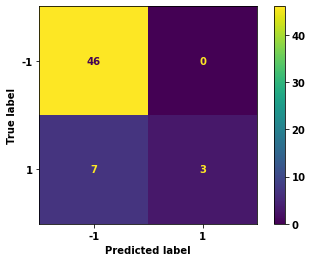

In [27]:
# Confusion matrix
cm = confusion_matrix(y_test_anomaly, y_test_predict)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[-1,1]).plot()
plt.show()

Check most contributing shapelets

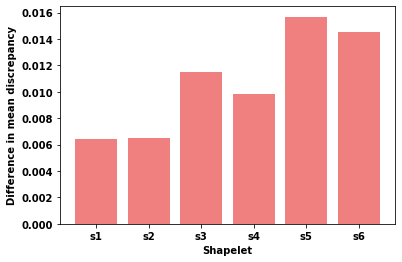

In [21]:
X_anomaly = X_test_transform[y_test_anomaly==-1]
X_normal = X_test_transform[y_test_anomaly==1]
X_anomaly = np.mean(X_anomaly, axis=0)
X_normal = np.mean(X_normal, axis=0)
diff = X_anomaly - X_normal

names=['s1', 's2', 's3','s4', 's5', 's6']
plt.figure()
plt.bar(names, diff, color='lightcoral')
plt.xlabel('Shapelet')
plt.ylabel('Difference in mean discrepancy')
plt.show()
# the fifth shapelet has greater difference in mean discrepancy

Align the 5th shapelet to some sample test series to explain the choice of the algorithm:

Anomaly:
Normal:


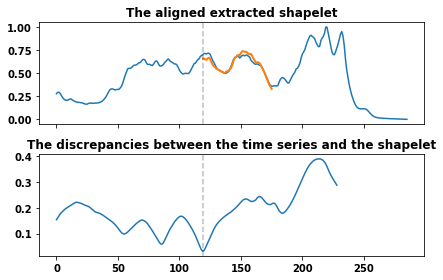

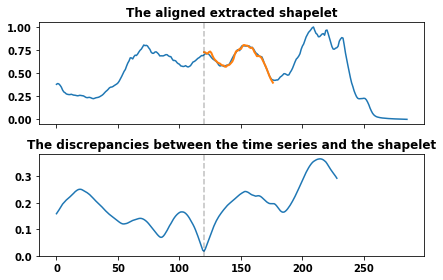

In [24]:
print("Anomaly:")
f, ax = plt.subplots(2, 1, sharex=True)

t = X_test_anomaly[y_test_anomaly==-1][10].flatten()

s = S[5].flatten()
distances = []
for i in range(len(t) - len(s)):
    distances.append(np.sqrt(length_normalized_distance(s,t[i:i+len(s)])))

pos = np.argmin(distances)
sequence = t[pos: pos + len(s)]

s = s - np.mean(s) + np.mean(sequence)
ax[0].plot(t)
ax[0].plot(np.arange(pos, pos + len(s)), s, linewidth=2)
ax[0].axvline(pos, color='k', linestyle='--', alpha=0.25)
ax[0].set_title("The aligned extracted shapelet", fontweight="bold")

ax[1].plot(distances)
ax[1].axvline(pos, color='k', linestyle='--', alpha=0.25)
ax[1].set_title('The discrepancies between the time series and the shapelet', fontweight="bold")

plt.tight_layout()

print("Normal:")
f, ax = plt.subplots(2, 1, sharex=True)

t = X_test_anomaly[y_test_anomaly==1][0].flatten()

s = S[5].flatten()
distances = []
for i in range(len(t) - len(s)):
    distances.append(np.sqrt(length_normalized_distance(s,t[i:i+len(s)])))

pos = np.argmin(distances)
sequence = t[pos: pos + len(s)]

s = s - np.mean(s) + np.mean(sequence)
ax[0].plot(t)
ax[0].plot(np.arange(pos, pos + len(s)), s, linewidth=2)
ax[0].axvline(pos, color='k', linestyle='--', alpha=0.25)
ax[0].set_title("The aligned extracted shapelet", fontweight="bold")

ax[1].plot(distances)
ax[1].axvline(pos, color='k', linestyle='--', alpha=0.25)
ax[1].set_title('The discrepancies between the time series and the shapelet', fontweight="bold")

plt.tight_layout()